<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 2: Deep learning для обработки звука</center></h2>

# Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения мел-спектрограммы.
* Рекуррентными и сверточными классификаторами аудиоданных.
* Алгоритмом аугментации аудиоданных SpecAugment.

In [1]:
!pip install torch==1.8.0 torchaudio==0.8.0 numpy==1.20.0

In [2]:
# Оформление 
from typing import List, Tuple, Dict, Union, Optional

# Картинки
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format ='retina'

from IPython.display import clear_output

# Фиксируем размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.sans-serif": ["Benton Sans"]})

# Аудио
from IPython import display

import torchaudio
from torchaudio.transforms import MelSpectrogram

# Основное
import os
from tqdm import tqdm
from itertools import islice

import pandas as pd
import numpy as np
import math

import torch
from torch import distributions
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import train_test_split

from dataclasses import dataclass
import librosa

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты. 

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов: 

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


## Задание 1 (1 балл). Знакомство с данными.

1. Скачайте датасет из [Google Drive](https://drive.google.com/file/d/12emmtpodmo1783e6VOOEjV20zAKl5dZR/view?usp=sharing) c и распакуйте в папку `./data`.

In [6]:
!wget https://www.dropbox.com/s/sbb9u0t88pim6g2/HW2_dataset.zip -O dataset.zip

--2021-04-05 13:11:31--  https://www.dropbox.com/s/sbb9u0t88pim6g2/HW2_dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sbb9u0t88pim6g2/HW2_dataset.zip [following]
--2021-04-05 13:11:31--  https://www.dropbox.com/s/raw/sbb9u0t88pim6g2/HW2_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb529261ff61db348d5c76bb1d2.dl.dropboxusercontent.com/cd/0/inline/BMCb4KlMwAeSMnLQ42AwteC8BT9mOg4vi57EDEfQ6vxutAO-ZhbZbW4fOPCjm5Dfy-F12rcfbsO6q4TPAGqXg2HfbAZNCUmNVBYj5m9jjRawJwu_ijG1EchZN_uEBLOsKsIQiwdOaiQGhz4DZcTzmc6j/file# [following]
--2021-04-05 13:11:31--  https://ucb529261ff61db348d5c76bb1d2.dl.dropboxusercontent.com/cd/0/inline/BMCb4KlMwAeSMnLQ42AwteC8BT9mOg4vi57EDEfQ6vxutAO-ZhbZbW4fOPCjm5Dfy-F12rcfbsO6q4

In [7]:
!unzip -q dataset.zip

In [8]:
!ls urbansound8k

data  train_part.csv  val_part.csv


2. Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` — аудиозапись, `y` — класс аудиозаписи, `len` — длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи, если она короче чем `pad_size` параметр, надо дополнять ее нулями.

In [3]:
# Классы данных
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
           'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 
           'siren', 'street_music']

In [4]:
class AudioDataset(Dataset):
    def __init__(self, path_to_csv: str, path_to_folder: str, pad_size: int=384000, sample_rate: int = 44100):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[['ID', 'Class']]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size
        self.sample_rate = sample_rate
        self.class_to_idx = {classes[i]: i for i in range(10)}


    def __getitem__(self, index: int):
        id, y = self.csv.iloc[index]
        y = classes.index(y)
        path = os.path.join(self.path_to_folder, str(id) + ".wav")

        # Скачиваем файл
        wav, sr = torchaudio.load(path)

        # Приводим аудиозапись к одному sample_rate
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            wav = resampler(wav)
        
        wav = wav.squeeze()

        # Сохраняем исходную длину аудиозаписи
        len_ = len(wav)

        # Паддим длину аудиозаписи, если она меньше pad_size
        if len_ < self.pad_size:
            wav_new = torch.zeros(self.pad_size, dtype=torch.float32)
            wav_new[:len_] = wav
            wav = wav_new
            
        item = {'x': wav, 'y': y, 'len': len_}

        return item

    def __len__(self):
        return self.csv.shape[0]

In [5]:
# Создадим датасеты
train_dataset = AudioDataset('urbansound8k/train_part.csv', 'urbansound8k/data')
val_dataset = AudioDataset('urbansound8k/val_part.csv', 'urbansound8k/data')

In [6]:
# Проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [7]:
# Проверим возращаемые значения __getitem__
item = train_dataset.__getitem__(0)

assert item['x'].shape == (384000, )
assert item['y'] == 0
assert item['len'] == 176400

3. С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.

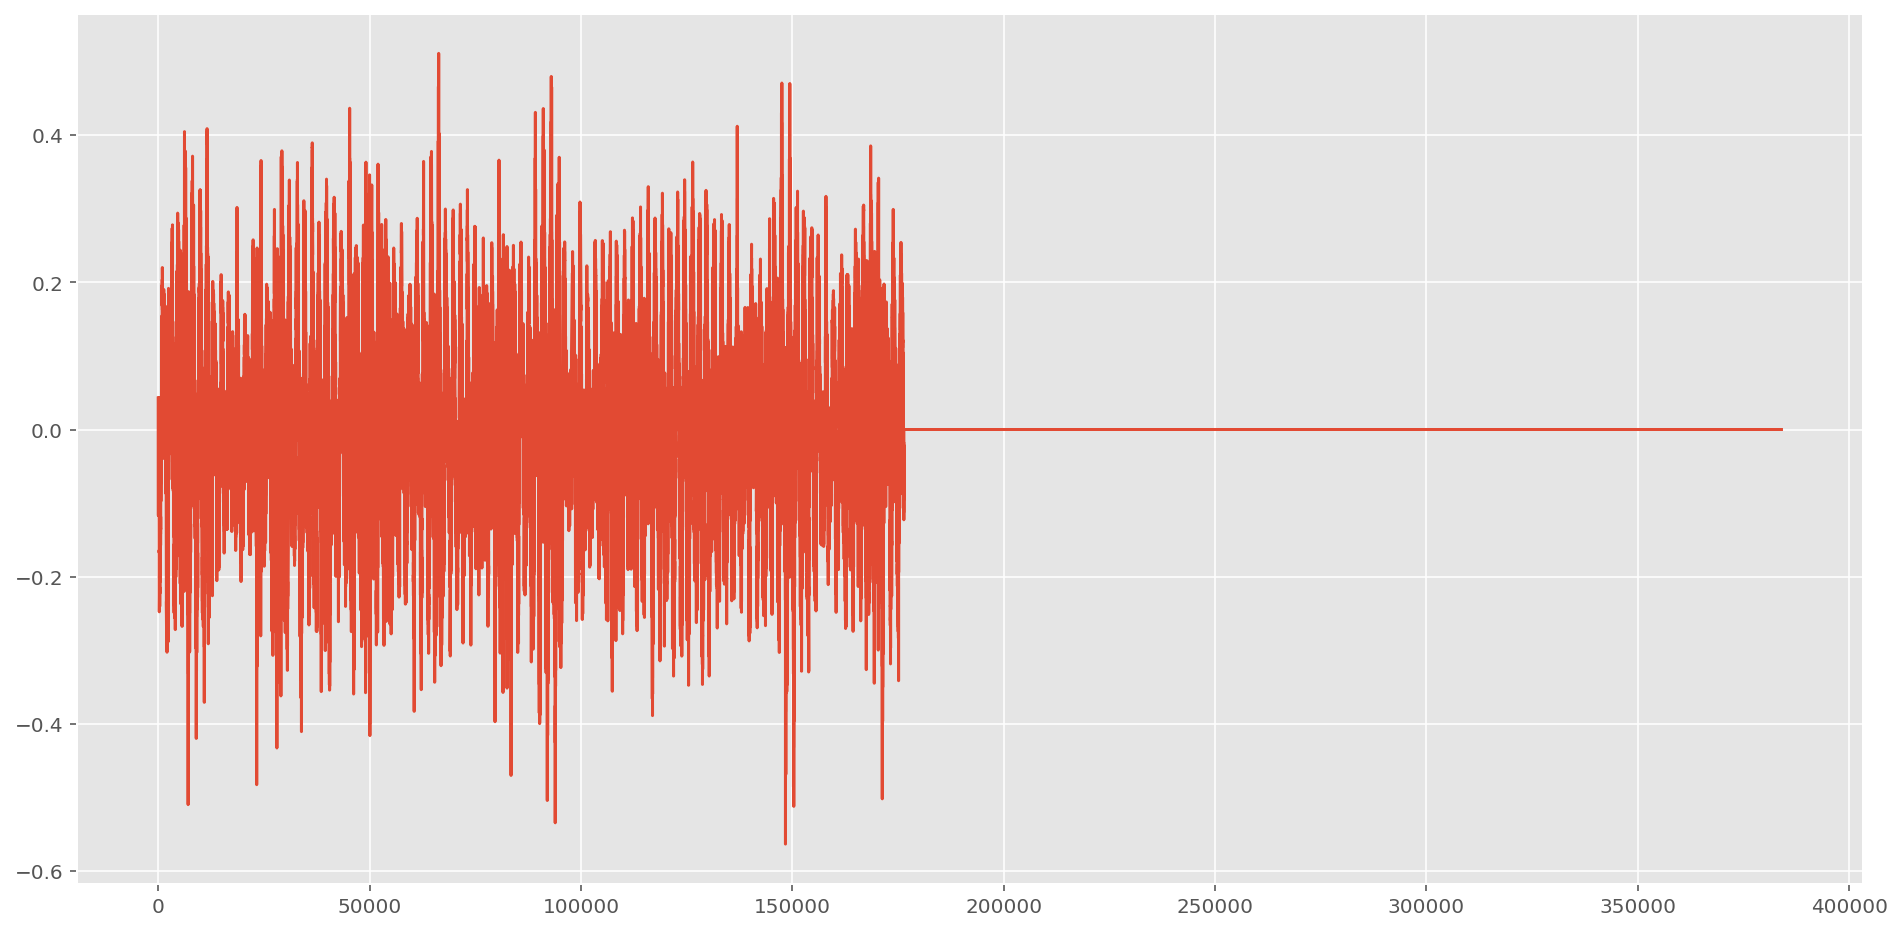

In [8]:
# Нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item['x'])

display.Audio(item['x'], rate=train_dataset.sample_rate)

In [9]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

In [10]:
# Создадим даталоадеры
set_seed(13)
train_dataloader = DataLoader(train_dataset, 32, shuffle=True, pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, 32, pin_memory=True)

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)

По своей сути аудиозапись является ни чем иным, как временным рядом: замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности. 

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

![title](https://github.com/hse-ds/iad-applied-ds/raw/7631ed4707ddbc54ff07e6df45999bee4266e330/2021/hw/hw2/imgs/rnn_raw.png)

*Совет*: для ускорения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [16]:
class RecurrentRawAudioClassifier(nn.Module):
  def __init__(self, num_classes=10, window_length=1024, hop_length=256, hidden=256, 
               num_layers=2):
    super().__init__()
    self.window_length = window_length
    self.hop_length = hop_length

    self.first_mlp = nn.Sequential(nn.Linear(window_length, 256),
                                   nn.BatchNorm1d(256),
                                   nn.ReLU(inplace=True), 
                                   nn.Linear(256, 64), 
                                   nn.BatchNorm1d(64),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(64, 16))

    self.rnn = nn.LSTM(input_size=16, hidden_size=hidden, num_layers=2, 
                       bidirectional=True, batch_first=True)
    
    self.final_mlp = nn.Sequential(nn.Linear(2 * hidden * 2, 256),
                                   nn.BatchNorm1d(256),
                                   nn.ReLU(inplace=True), 
                                   nn.Linear(256, 10))
   
  def forward(self, x, lens):
    # Разбиваем сигнал на окна 
    # batch_windows.shape == (B, NUM WINDOWS, 1024)
    batch_windows = x.unfold(dimension=-1,size=self.window_length, step=self.hop_length)

    # Применяем к каждому окну полносвязную сеть
    # batch_windows_feautures.shape == (B, NUM WINDOWS, 16)
    batch_windows_feautures = torch.zeros(size=(x.shape[0], batch_windows.shape[1], 16)).to(device)

    # Проходим по каждому сэмплу в батче
    for i in range(x.shape[0]):
        # Для каждый сэмпл прогоняем через MLP 
        batch_windows_feautures[i] = self.first_mlp(batch_windows[i])

    # Применяем к получившемся последовательностям LSTM и берем hidden state
    output, states = self.rnn(batch_windows_feautures)
    h_n, c_n = states  

    # Склеиваем hidden_state по слоям
    # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
    hidden_flattened = torch.hstack([h_n[i] for i in range(h_n.shape[0])])

    # Примеяем полносвязную сеть и получаем логиты классов
    out = self.final_mlp(hidden_flattened)

    return out

Обучим получившуюся модель.

In [17]:
def train_audio_clfr(model, optimizer, train_dataloader, sr,
                     criterion=torch.nn.CrossEntropyLoss(),
                     data_transform=None, augmentation=None,
                     num_epochs=10, device='cuda:0', verbose_num_iters=10):
  model.train()
  iter_i = 0

  train_losses = []
  train_accuracies = []

  for epoch in range(num_epochs):  
    for batch in train_dataloader:
        x = batch['x'].to(device)
        y = batch['y'].to(device)
        lens = batch['len'].to(device)
        
        # Применяем преобразование входных данных
        if data_transform:
          x, lens = data_transform(x, lens, device=device, sr=sr)

        # Примеменяем к логмелспектрограмме аугментацию
        if augmentation:
          x, lens = augmentation(x, lens)

        # Делаем предсказания
        probs = model(x, lens)

        # Делаем шаг градиента
        optimizer.zero_grad()
        loss = criterion(probs, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        # Считаем точность предсказания
        pred_cls = probs.argmax(dim=-1)
        train_accuracies.append((pred_cls == y).float().mean().item())
    
        iter_i += 1

        # Раз в verbose_num_iters визуализируем наши лоссы и семплы
        if iter_i % verbose_num_iters == 0:
            clear_output(wait=True)

            print(f'Epoch {epoch}')

            plt.figure(figsize=(10, 5))
                
            plt.subplot(1, 2, 1)
            plt.xlabel('Iteration')
            plt.ylabel('Train loss')
            plt.plot(np.arange(iter_i), train_losses)

            plt.subplot(1, 2, 2)
            plt.xlabel('Iteration')
            plt.ylabel('Train acc')
            plt.plot(np.arange(iter_i), train_accuracies)

            plt.show()

  model.eval()

In [18]:
# Создадим объекты модели 
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device)

RecurrentRawAudioClassifier(
  (first_mlp): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=16, bias=True)
  )
  (rnn): LSTM(16, 256, num_layers=2, batch_first=True, bidirectional=True)
  (final_mlp): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [19]:
# Оптимизатор
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


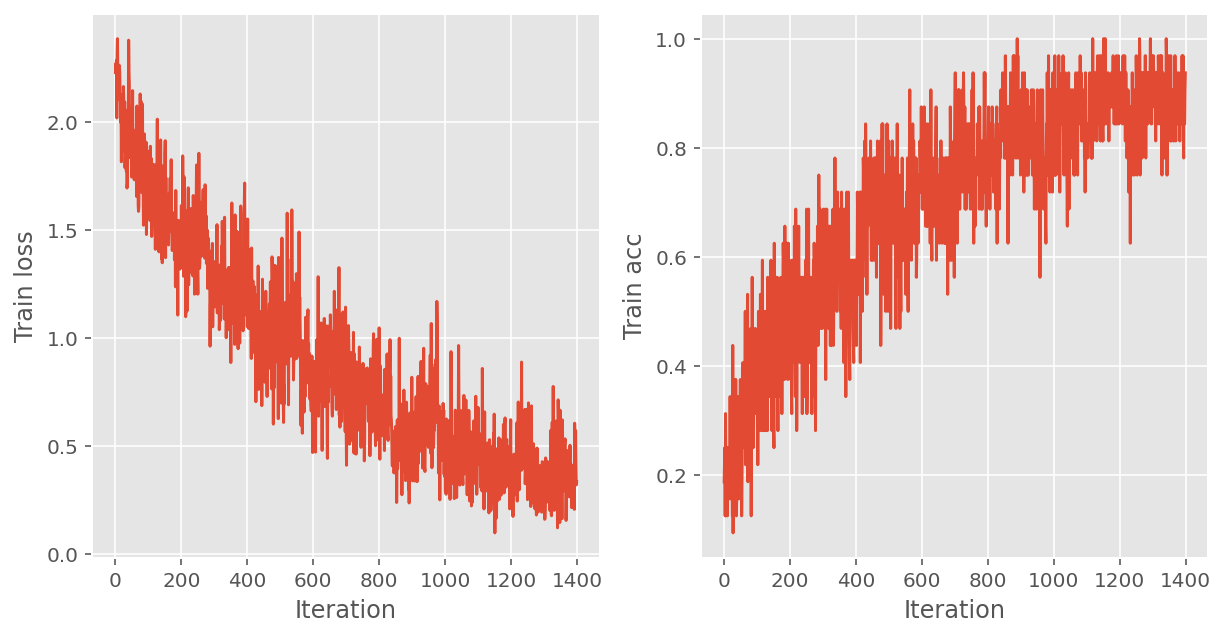

In [20]:
# Обучим модель
set_seed(13)
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sample_rate)

Посчитаем метрики на валидационном датасете.

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
  pred_true_pairs = []
  for batch in val_dataloader:
        x = batch['x'].to(device)
        y = batch['y'].to(device)
        lens = batch['len'].to(device)
        
        with torch.no_grad():
          if data_transform:
            x, lens = data_transform(x, lens, sr=sr, device=device)

          probs = model(x, lens)

          pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
          pred_true_pairs.append((pred, true))

  print(f'Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs]):.4}')

  cm_df = pd.DataFrame(
      confusion_matrix([p[1] for p in pred_true_pairs], 
                       [p[0] for p in pred_true_pairs], 
                       normalize='true'),
      columns=classes, index=classes)
  sns.heatmap(cm_df, annot=True)

Val accuracy: 0.1626


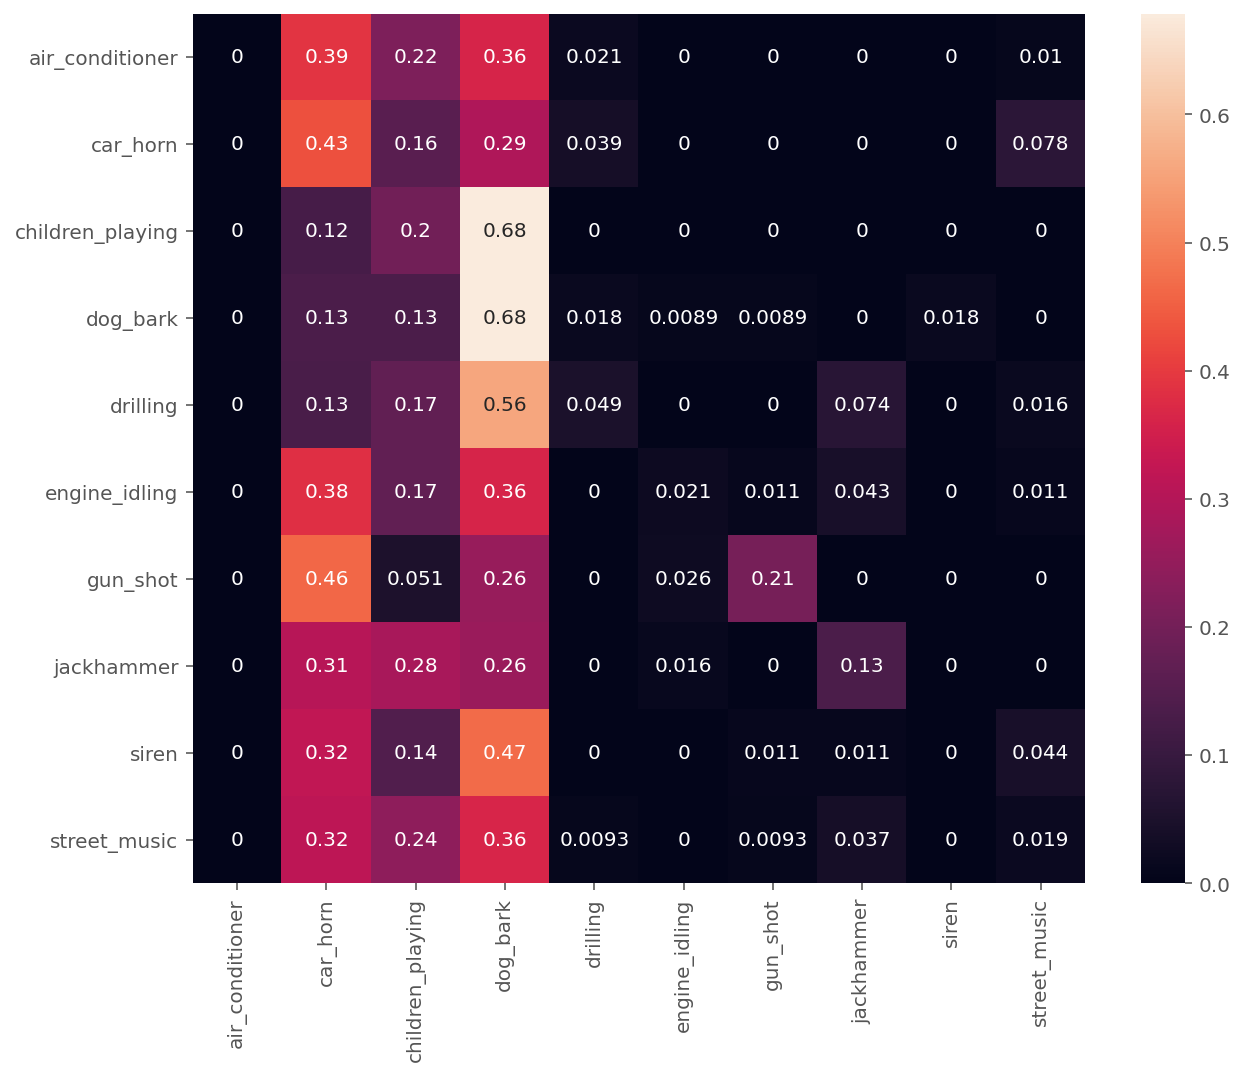

In [22]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sample_rate, device)

Сильно ли отличается качество модели на тренировочной и валидационной выборке? Если да, то как думаете, в чем причина?

**Ответ**: Да, на валидационной выборке качество намного хуже — модель не смогла обобщить законномерности в данных и переобучилась. Причина такого исхода описана в начале следующего задания: сырой сигнал не очень подходит в качестве данных для обучения нейронной сети, поскольку он чувствителен ко многим факторам. Следовательно, модель может легко переобучиться, что и произошло в нашем случае.

## Задание 3. Построение мел-cпектрограмм. (2 балла)

Сырой сигнал очень чувствителен ко многим факторам: увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных — спектрограмму, в том числе мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в мел-шкалу.

![image](https://antkillerfarm.github.io/images/img2/Spectrogram_5.png)

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [23]:
# Референсная функця
def compute_log_melspectrogram_reference(wav_batch, lens, sr):
    featurizer = MelSpectrogram(sample_rate=sr, n_fft=1024, win_length=1024,
                                hop_length=256, n_mels=64, center=False).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

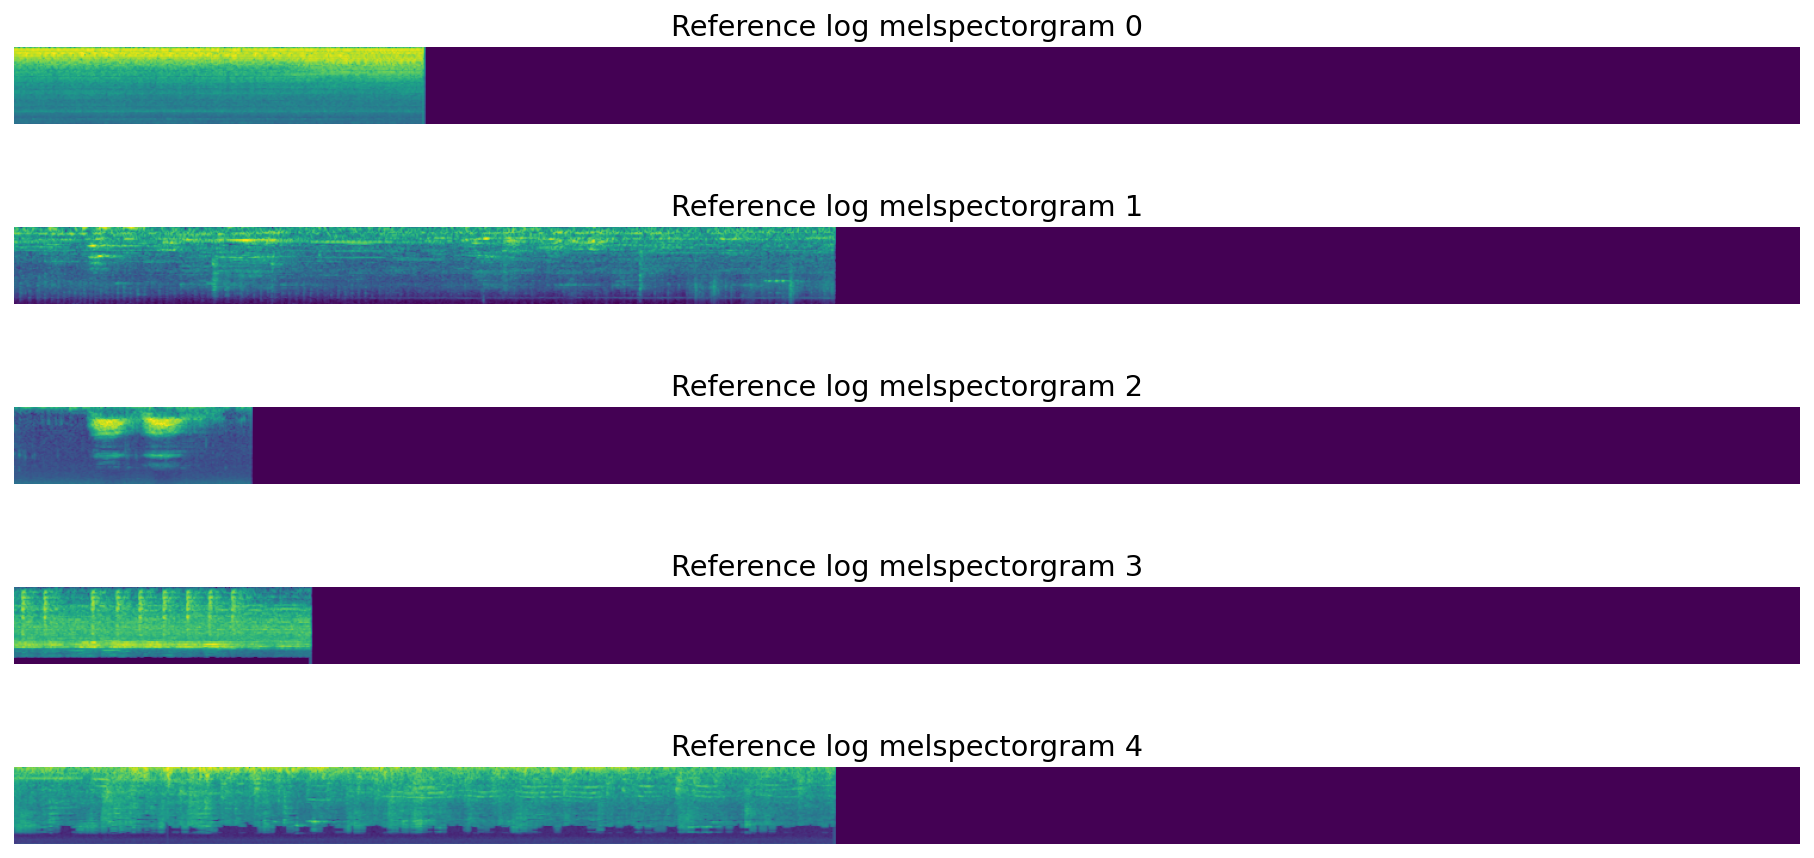

In [24]:
# Возьмем случайный батч
for batch in train_dataloader:
  break

wav_batch = batch['x'].to(device)
lens = batch['len'].to(device)

# Посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sample_rate)

# Нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
  axes[i].axis('off')
  axes[i].set_title(f'Reference log melspectorgram {i}')
  axes[i].imshow(log_melspect[i].to('cpu').numpy())

Теперь сделаем то же самое сами. 

In [25]:
sr = train_dataset.sample_rate
n_fft=1024
win_length=1024
hop_length=256
n_mels=64


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [26]:
windows = wav_batch.unfold(dimension=-1, size=win_length, step=hop_length)
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

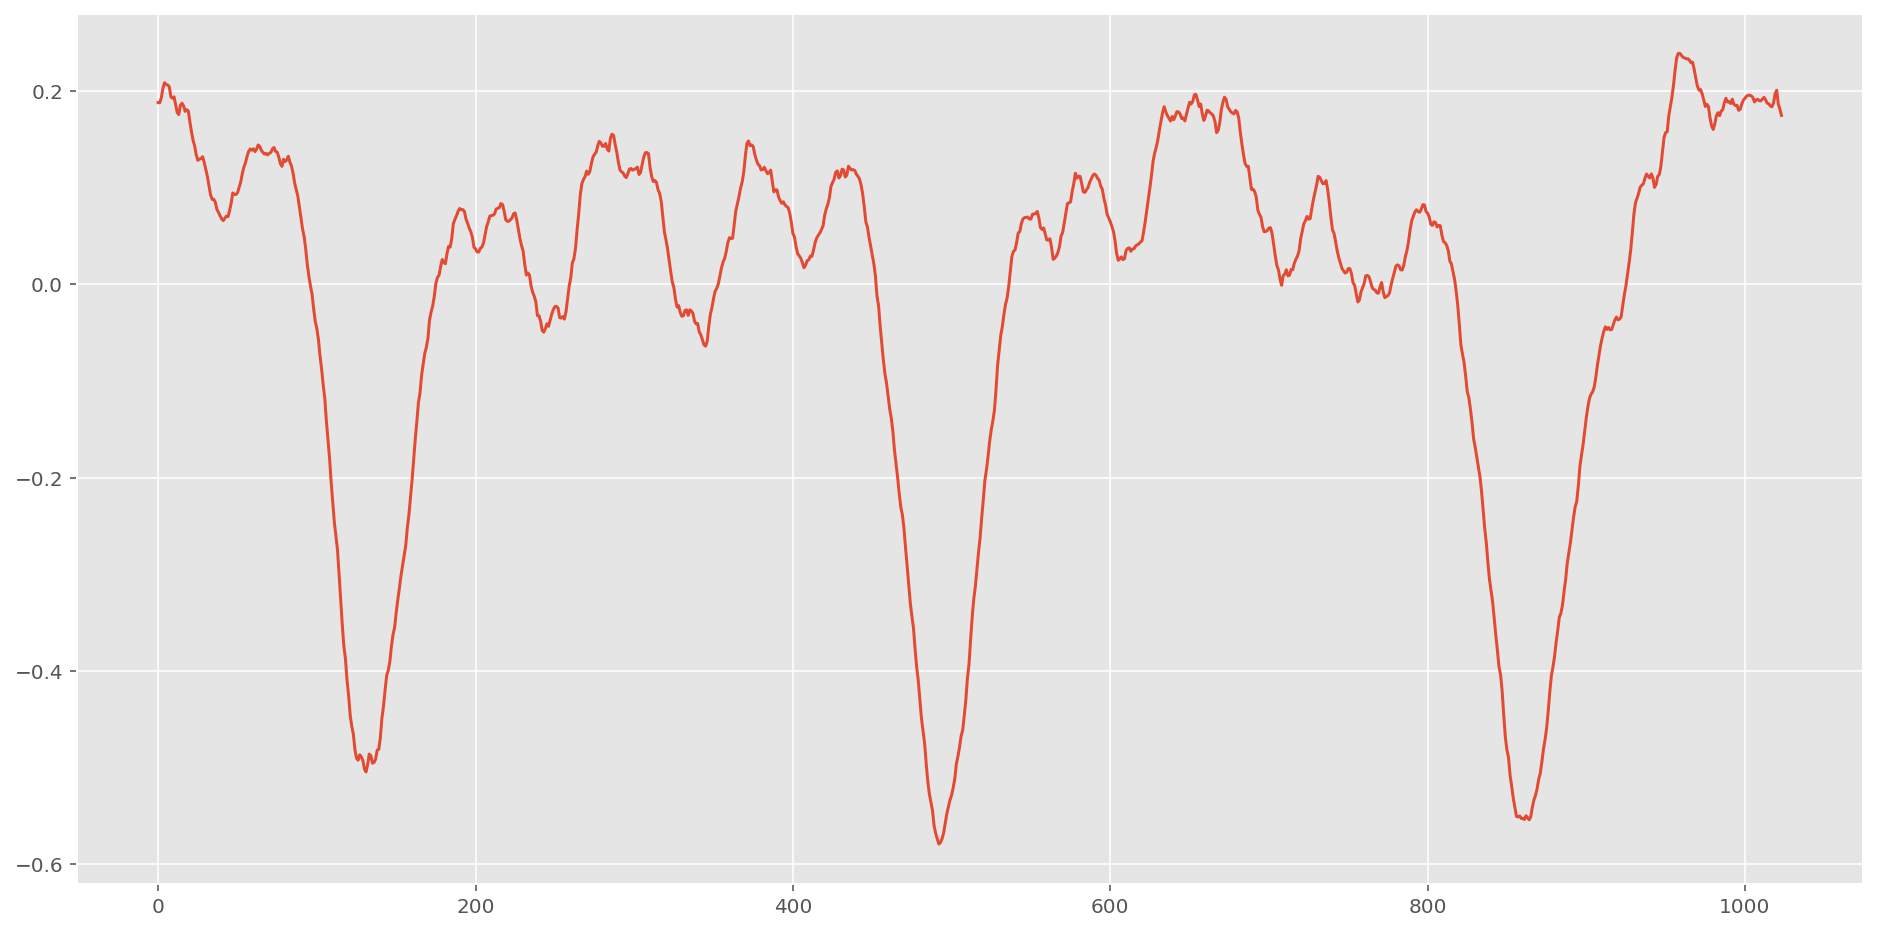

In [27]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0].to('cpu'))

display.Audio(windows[0, 0].to('cpu'), rate=train_dataset.sample_rate)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [28]:
filter = torch.hann_window(window_length=win_length).to(device)
windows_with_applied_filter = windows * filter[None, None, :]

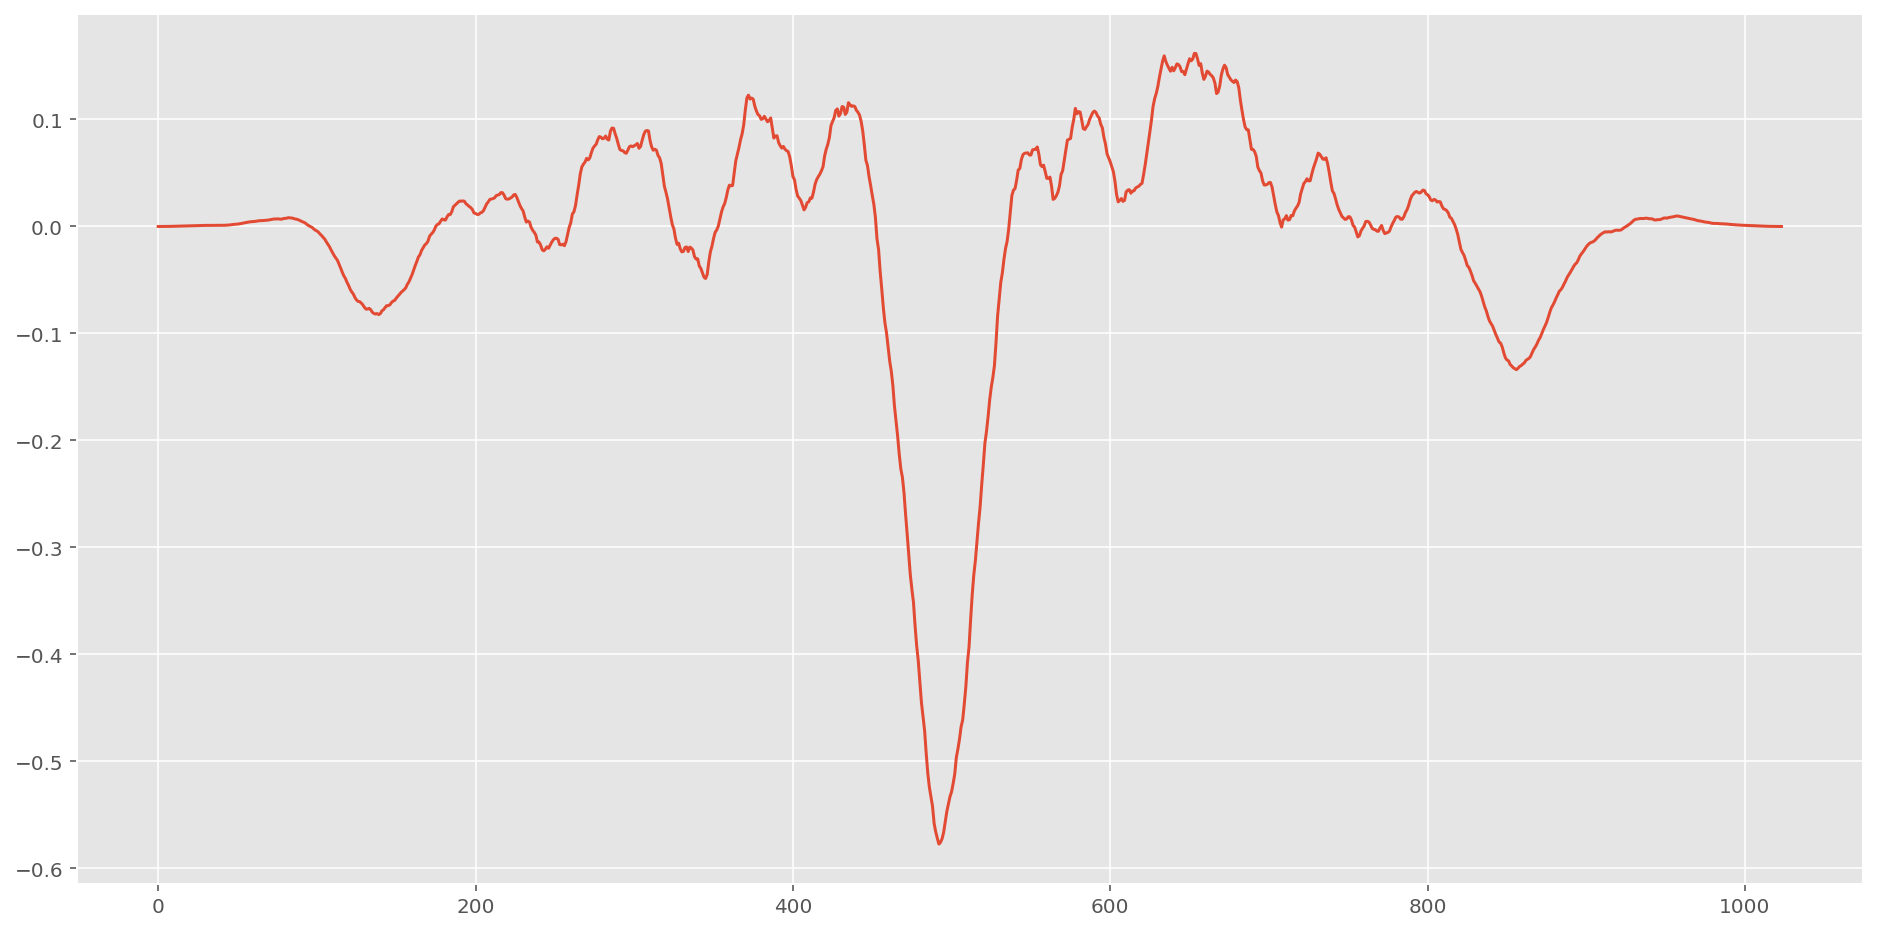

In [29]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0].to('cpu'))

display.Audio(windows_with_applied_filter[0, 0].to('cpu'), rate=train_dataset.sample_rate)

С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

In [30]:
n_fft = torch.fft.fft(windows_with_applied_filter).shape[2]
fft_features = torch.fft.fft(windows_with_applied_filter)[:, :, :n_fft // 2 + 1]
fft_magnitudes = torch.abs(fft_features ** 2)
assert fft_magnitudes.shape == (32, 1497, 513)

Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в мел-шкалу.

In [31]:
melscale = torchaudio.transforms.MelScale(sample_rate=train_dataset.sample_rate, n_mels=64, n_stft=n_fft//2+1)

Нелинейное преобразование для перевода в мел-шкалу выглядит следующим образом.

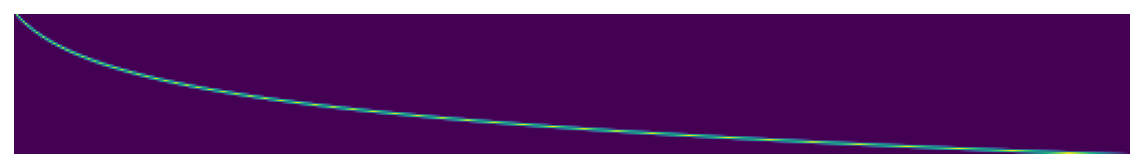

In [32]:
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(melscale.fb.numpy().transpose());

Примените мел-шкалу к магнитудам.

In [33]:
melscale.to(device);

In [34]:
mel_spectrogram = melscale(fft_magnitudes.transpose(1, 2))
assert mel_spectrogram.shape == (32, 64, 1497)

Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной мел-спектрограммы.

In [35]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные мел-Спектрограммы должны совпадать с референсными.

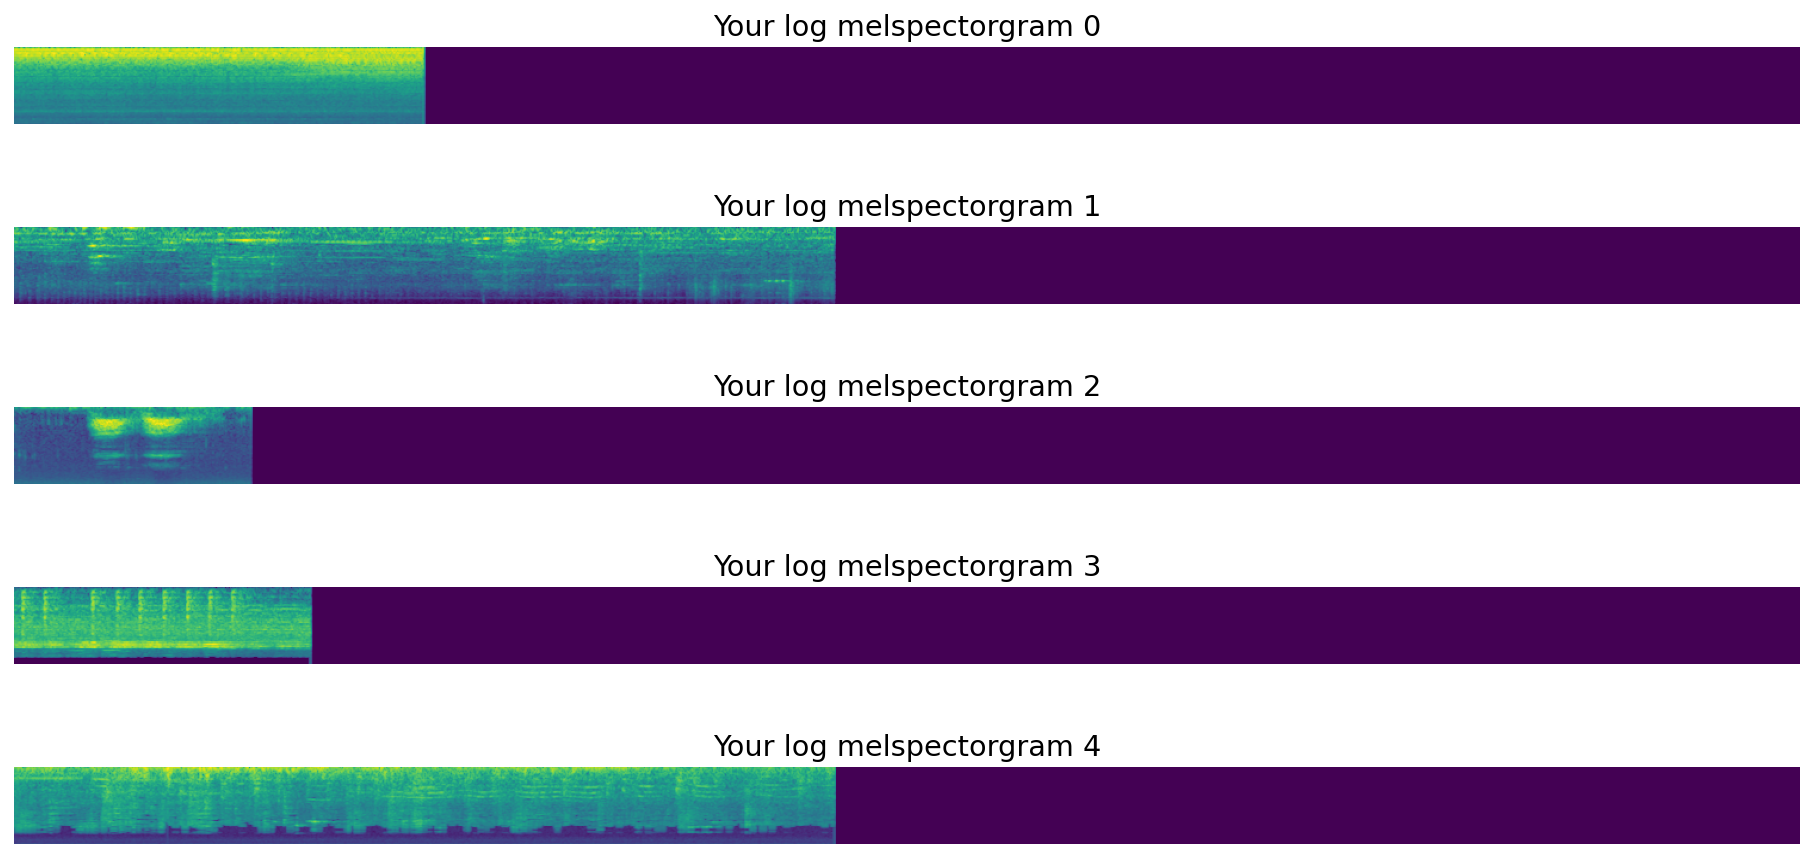

In [36]:
# Нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
  axes[i].axis('off')
  axes[i].set_title(f'Your log melspectorgram {i}')
  axes[i].imshow(logmel_spectrogram[i].to('cpu').numpy())

Теперь оформим эту логику в функцию.

In [37]:
def compute_log_melspectrogram(wav_batch, lens, sr, device='cuda:0'):
    # Разделим аудиосигнал на окна 
    windows = wav_batch.unfold(dimension=-1, size=win_length, step=hop_length)

    # Применим косинуисальный фильтр к сигналу из окна
    filter = torch.hann_window(window_length=win_length).to(device)
    windows_with_applied_filter = windows * filter[None, None, :]

    # Применим дискретное преобразование Фурье к каждому окну
    n_fft = torch.fft.fft(windows_with_applied_filter).shape[2]
    fft_features = torch.fft.fft(windows_with_applied_filter)[:, :, :n_fft//2+1]
    fft_magnitudes = torch.abs(fft_features ** 2)

    # Делаем нелинейное преобразование для перевода в мел-шкалу 
    melscale = torchaudio.transforms.MelScale(sample_rate=train_dataset.sample_rate, n_mels=64, n_stft=n_fft//2+1).to(device)
    mel_spectrogram = melscale(fft_magnitudes.transpose(1, 2))
    logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))

    return logmel_spectrogram, lens // 256

Финальная проверка.

In [38]:
assert torch.allclose(compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sample_rate)[0],
                      compute_log_melspectrogram(wav_batch, lens, train_dataset.sample_rate)[0],
                      atol=1e-5)

## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

![arch_mel](https://github.com/hse-ds/iad-applied-ds/raw/7631ed4707ddbc54ff07e6df45999bee4266e330/2021/hw/hw2/imgs/rnn_mel.png)

**За реализацию архитектуры дается 0.5 балла.**

In [39]:
class RecurrentMelSpectClassifier(nn.Module):
    def __init__(self, num_classes=10, window_length=1024, hop_length=256, 
                  hidden=256, num_layers=2):
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        self.rnn = nn.LSTM(input_size=64, hidden_size=hidden, num_layers=2, 
                          bidirectional=True, batch_first=True)
        
        self.final_mlp = nn.Sequential(nn.Linear(2 * hidden * 2, 256),
                                      nn.BatchNorm1d(256),
                                      nn.ReLU(inplace=True), 
                                      nn.Linear(256, 10))
    def forward(self, x, lens):
        # Применяем LSTM и берем hidden state
        output, states = self.rnn(x.permute(0, 2, 1))
        h_n, c_n = states  

        # Склеиваем hidden_state по слоям
        hidden_flattened = torch.hstack([h_n[i] for i in range(h_n.shape[0])])

        # Применяем полносвязную сеть и получаем логиты классов
        out = self.final_mlp(hidden_flattened)
        return out
   

In [40]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device);

optim = torch.optim.Adam(rnn_mel.parameters(), lr=3e-4)

Epoch 19


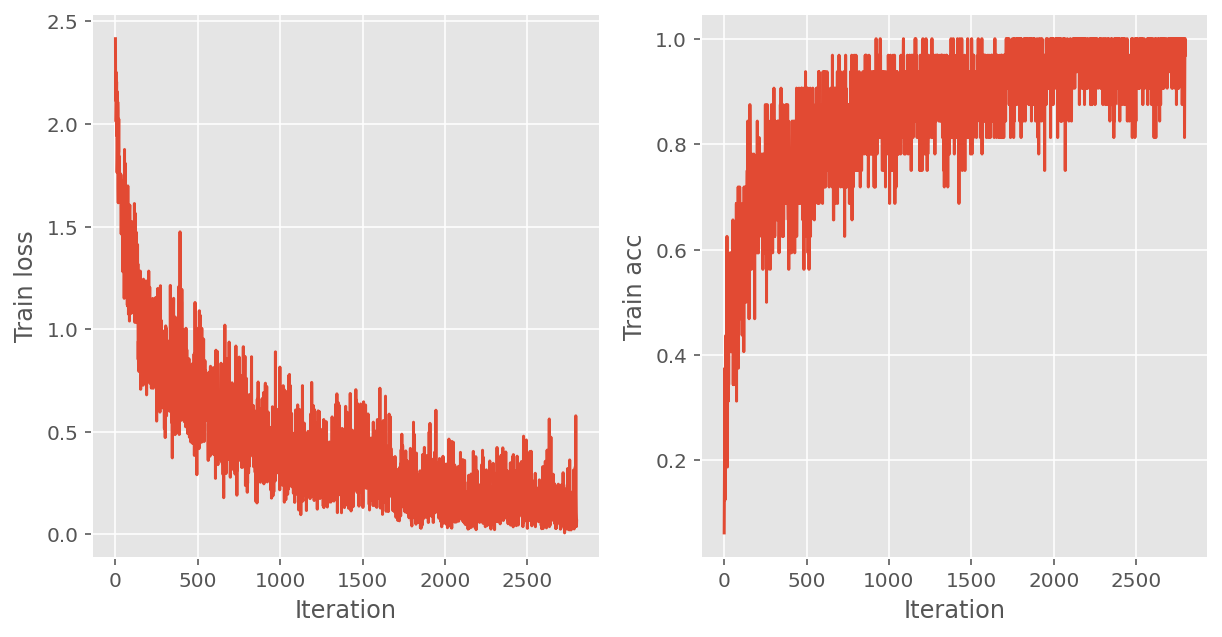

In [41]:
set_seed(13)
train_audio_clfr(rnn_mel, optim, train_dataloader, train_dataset.sample_rate, 
                 data_transform=compute_log_melspectrogram, num_epochs=20)

Посчитаем метрики на валидационном датасете.

Val accuracy: 0.8791


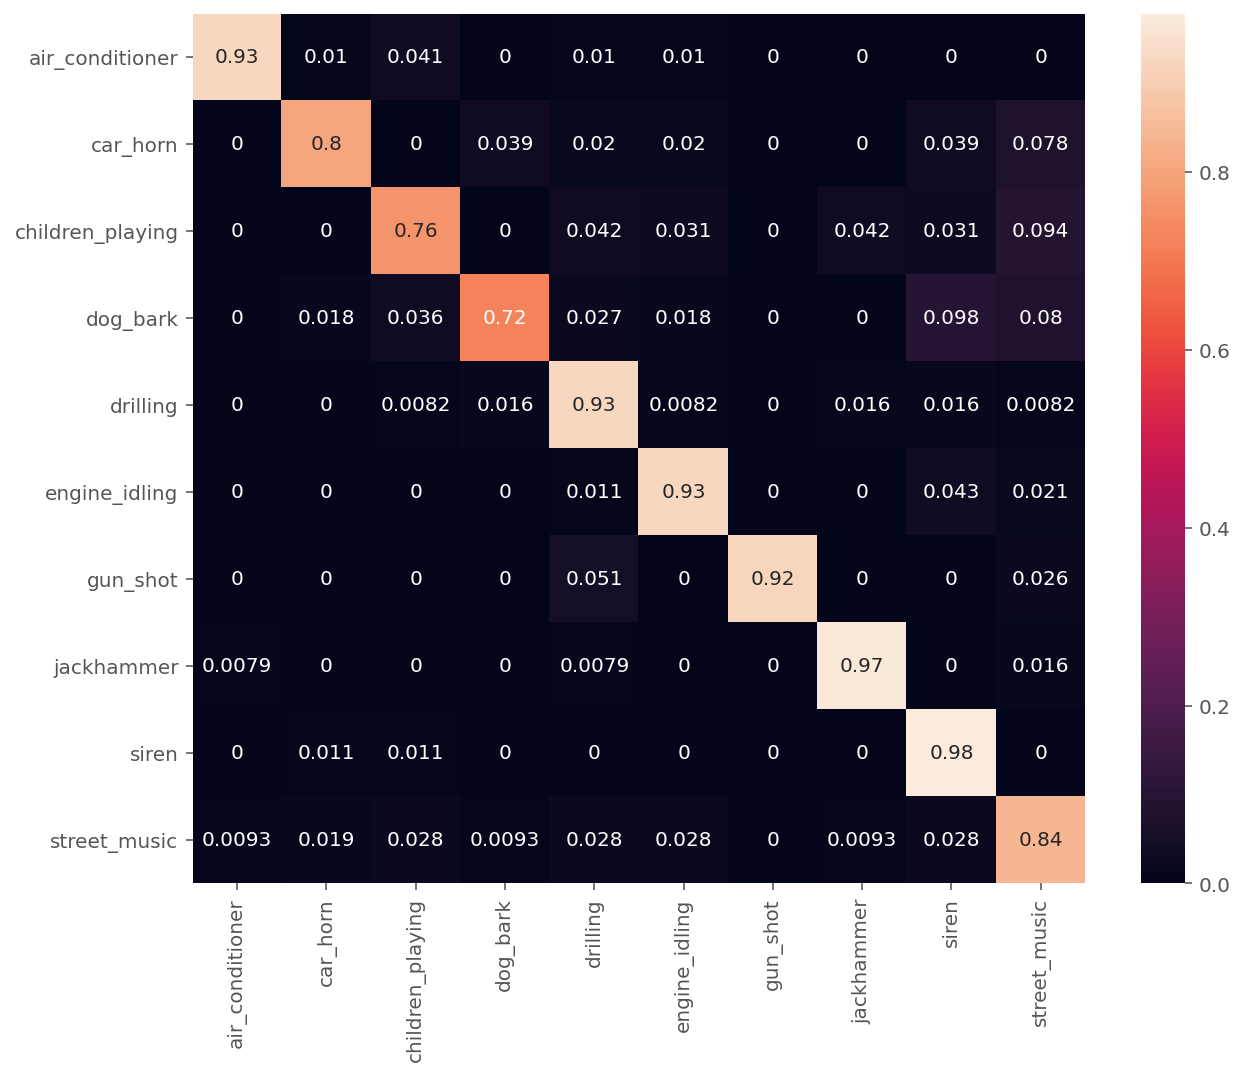

In [42]:
plot_confusion_matrix(rnn_mel, val_dataloader, train_dataset.sample_rate, device, 
                      data_transform=compute_log_melspectrogram)

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

Уже получили качество выше 0.8 (увеличил число эпох — один из гиперпараметров).

## Задание 5. Cверточная сеть для классификации аудиозаписей по мел-спектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны: если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

In [43]:
class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()

        self.cnn_backbone = nn.Sequential(self.get_cnn_block(in_channels=1, out_channels=16),
                                          self.get_cnn_block(in_channels=16, out_channels=32),
                                          self.get_cnn_block(in_channels=32, out_channels=64),
                                          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                          nn.BatchNorm2d(128),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2),
                                          nn.BatchNorm2d(128),
                                          nn.ReLU(inplace=True))

        self.final_mlp = nn.Sequential(nn.Linear(in_features=128, out_features=128),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(in_features=128, out_features=10))
    
    def get_cnn_block(self, in_channels, out_channels):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3),
                             nn.BatchNorm2d(out_channels),
                             nn.ReLU(inplace=True),
                             nn.Conv2d(out_channels, out_channels, kernel_size=3),
                             nn.BatchNorm2d(out_channels),
                             nn.ReLU(inplace=True),
                             nn.MaxPool2d(2, 2))

    def forward(self, x, lens):
        z = self.cnn_backbone(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)

In [44]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 13


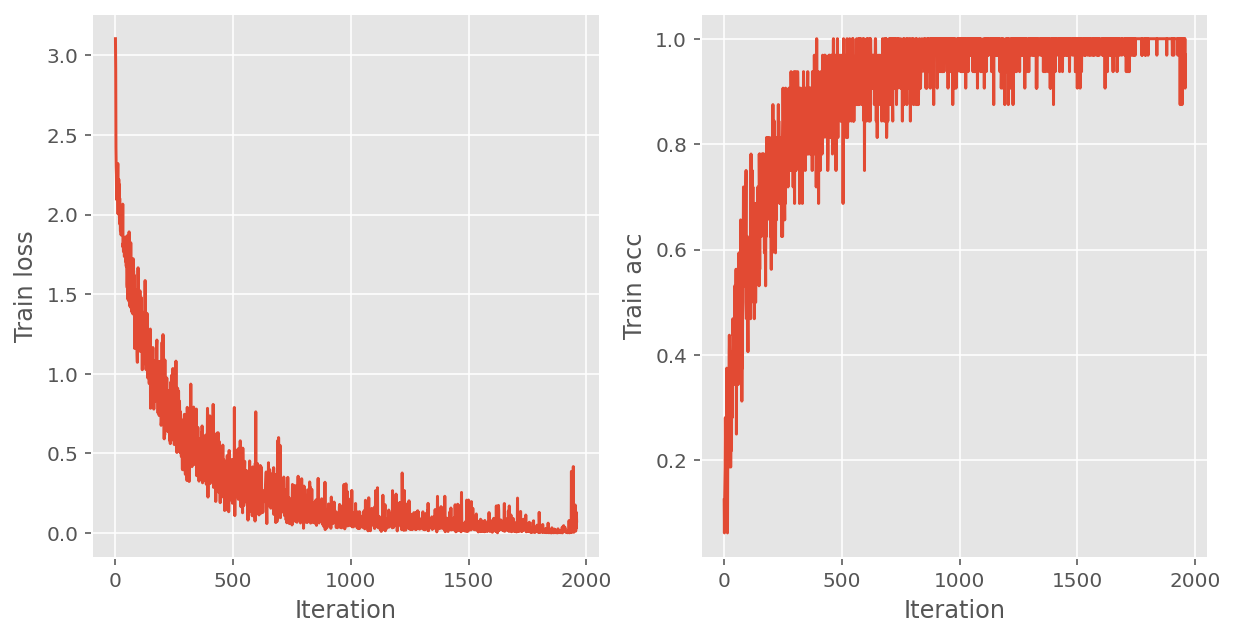

In [45]:
set_seed(13)
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sample_rate, 
                 data_transform=compute_log_melspectrogram,
                 num_epochs=14)

Val accuracy: 0.8888


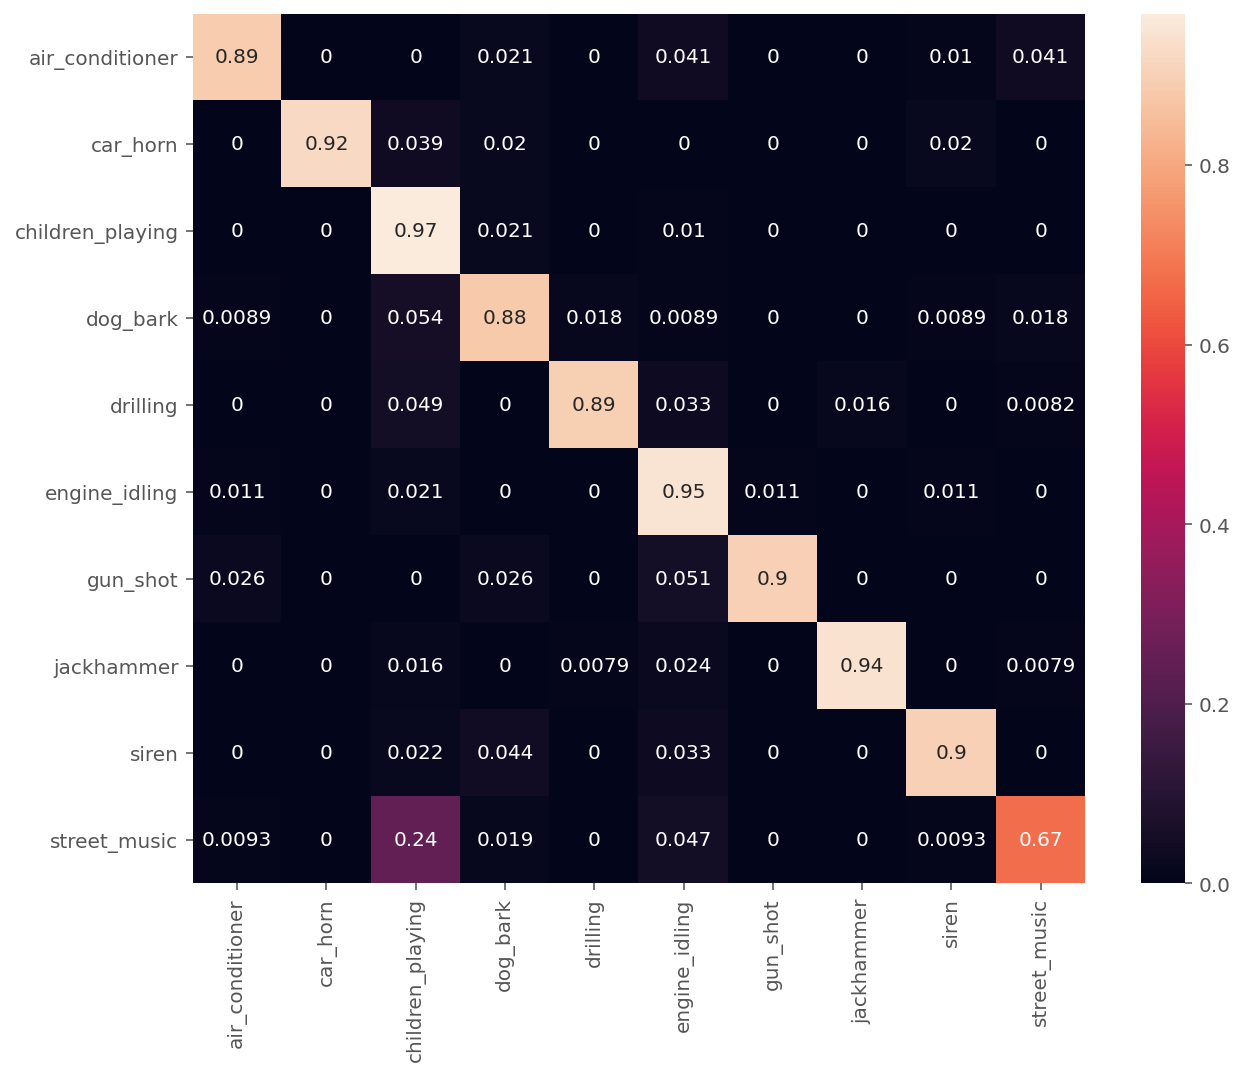

In [46]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sample_rate, device, 
                      data_transform=compute_log_melspectrogram)

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

Уже достигли качества выше 0.85.

## Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример — всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост: зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


In [47]:
import random 

class SpectAugment:
    def __init__(self, filling_value = 'mean', n_freq_masks = 2, n_time_masks = 2,
                 max_freq = 10, max_time = 50):
        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

        if self.filling_value == 'const':
            self.value = int(input('Choose const.'))

    def __call__(self, spects, lens):
        augmented_spects = torch.zeros_like(spects)

        for i in range(spects.shape[0]):
            spect_ = spects[i][:, :lens[i]].clone()

            if self.filling_value == 'mean':
                v = spect_.mean()
            elif self.filling_value == 'min':
                v = spect_.min()
            elif self.filling_value == 'max':
                v = spect_.max()
            elif self.filling_value == 'const':
                v = self.value
            else:
                ValueError("Choose mean, min, max or const method only.")

            for _ in range(self.n_freq_masks):
                m_1 = np.random.randint(0, spect_.shape[0])
                m_2 = m_1 + random.randrange(0, self.max_freq)
                spect_[m_1:m_2, :].fill_(v)
            
            for _ in range(self.n_time_masks):
                t_1 = np.random.randint(0, spect_.shape[1])
                t_2 = t_1 + random.randrange(0, self.max_time)
                spect_[:, t_1:t_2].fill_(v)
            
            augmented_spects[i] = torch.hstack((spect_, spects[i][:, lens[i]:]))
      
        return augmented_spects, lens

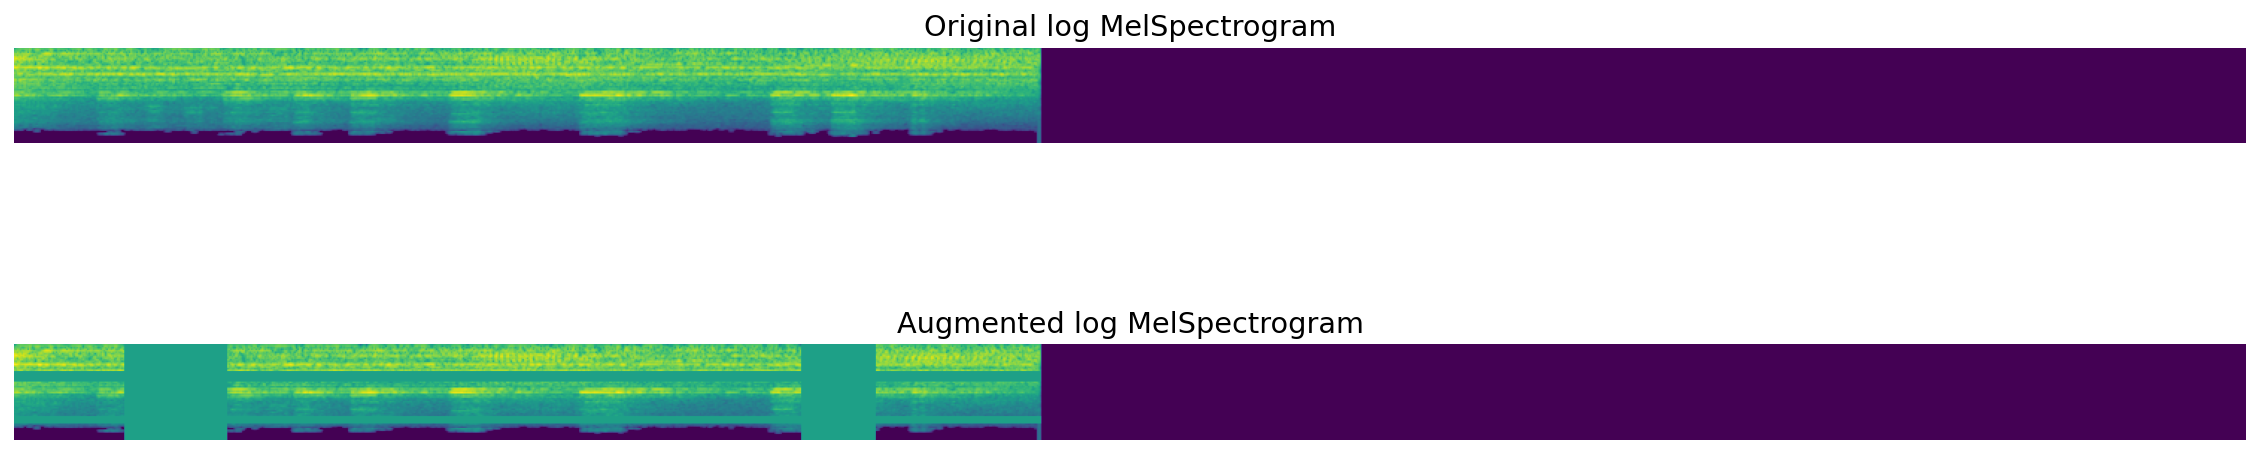

In [48]:
# Применим аугментацию к данным
augmentation = SpectAugment(max_time=70, max_freq=20)

for batch in train_dataloader:
  break

x = batch['x'].to(device)
lens = batch['len'].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(x, lens, sr=train_dataset.sample_rate)
x_logmel_augmented, lens = augmentation(x_logmel, lens)

# Нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title('Original log MelSpectrogram')
plt.axis('off')
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title('Augmented log MelSpectrogram')
plt.axis('off')
plt.imshow(x_logmel_augmented[0].cpu().numpy())

In [49]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


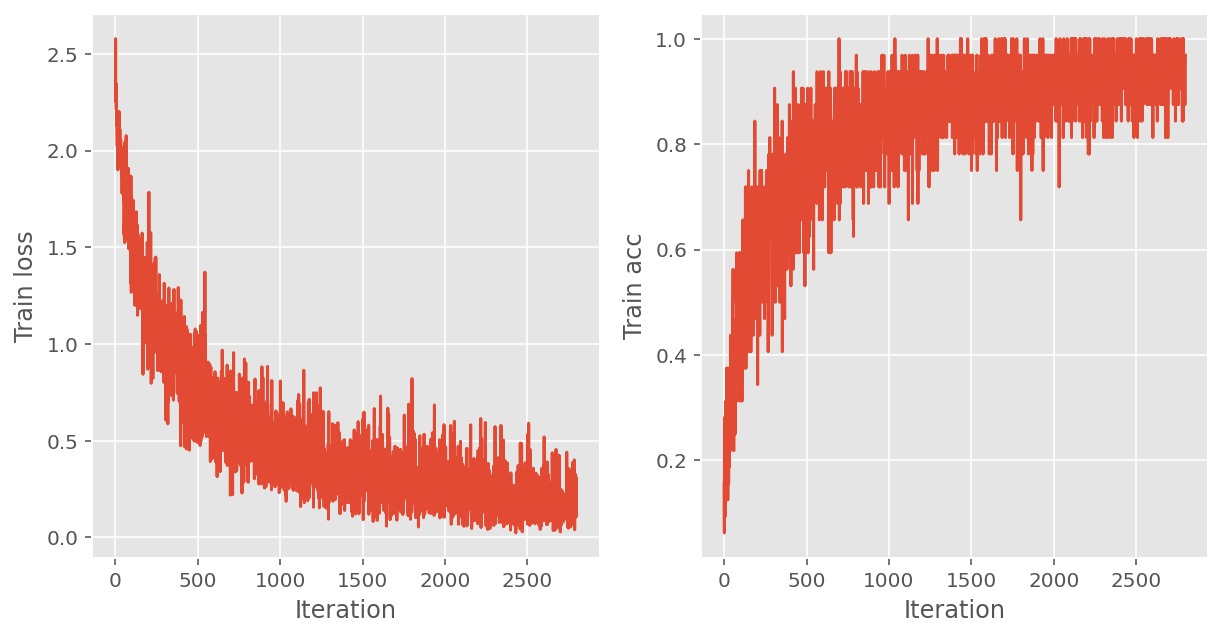

In [50]:
# Обучим модель на данных с аугментациями
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sample_rate, 
                 data_transform=compute_log_melspectrogram,
                 augmentation=SpectAugment(),
                 num_epochs=20)

Val accuracy: 0.9358


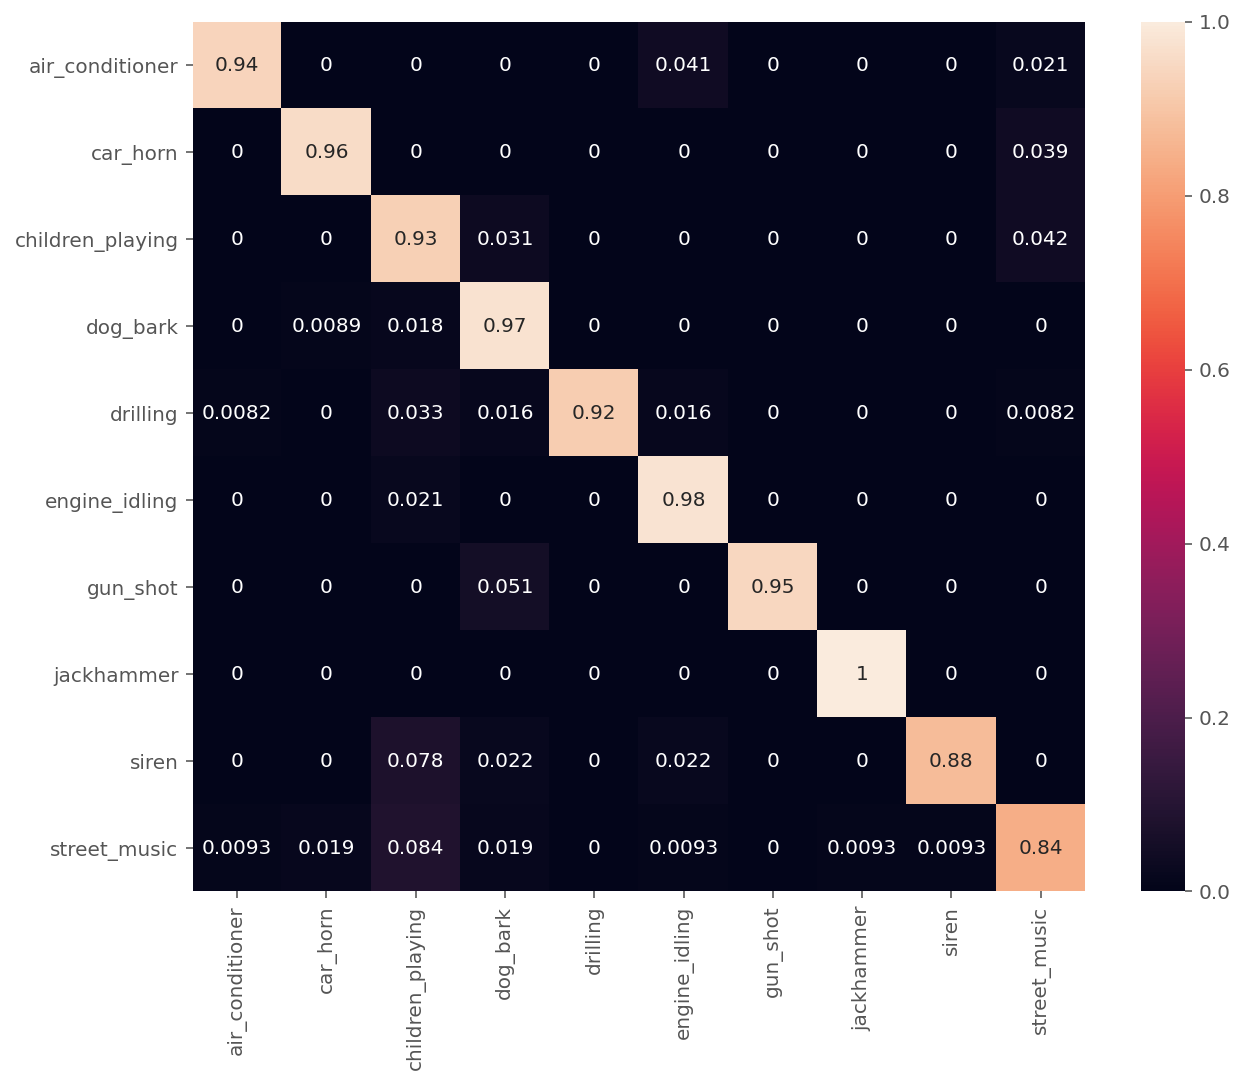

In [51]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sample_rate, device, 
                      data_transform=compute_log_melspectrogram)

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

Уже добились качества выше 0.9.